In [54]:
import os.path
import re
import sys
import tarfile
import time
import multiprocessing as mp
import itertools

import tensorflow.python.platform
from six.moves import urllib
import numpy as np
import tensorflow as tf
import h5py
import glob
import cPickle as pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.python.platform import gfile

from run_inference import predict_star, predict

%matplotlib inline
%load_ext autoreload
%autoreload 2

BOTTLENECK_TENSOR_NAME = 'pool_3/_reshape'
BOTTLENECK_TENSOR_SIZE = 2048
MODEL_INPUT_WIDTH = 299
MODEL_INPUT_HEIGHT = 299
MODEL_INPUT_DEPTH = 3
JPEG_DATA_TENSOR_NAME = 'DecodeJpeg/contents'
RESIZED_INPUT_TENSOR_NAME = 'ResizeBilinear'

def ensure_name_has_port(tensor_name):
  """Makes sure that there's a port number at the end of the tensor name.

  Args:
    tensor_name: A string representing the name of a tensor in a graph.

  Returns:
    The input string with a :0 appended if no port was specified.
  """
  if ':' not in tensor_name:
    name_with_port = tensor_name + ':0'
  else:
    name_with_port = tensor_name
  return name_with_port

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def create_graph(pb_file):
    """"Creates a graph from saved GraphDef file and returns a Graph object.
    Returns:
    Graph holding the trained Inception network.
    """
    model_filename = pb_file
    with gfile.FastGFile(model_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        tf.import_graph_def(graph_def, name='')

In [24]:
#create_graph("/data/retrain_manualtags1/output_graphfinal.pb")
create_graph("/data/classify_image_graph_def.pb")
sess = tf.InteractiveSession()

In [4]:
params = pickle.load(open("/data/datenet_decorations_outputs/output_params7600.pkl", 'r'))  # use 7600 for decorations; top-1 = 65.5%
fw = params["final_weights"]
fb = params["final_biases"]
print fb.shape
print fw.shape

(7,)
(2048, 7)


In [7]:
# I currently don't know what labels correspond to each of the 7 elements; will figure out

In [5]:
# from http://www.socouldanyone.com/2013/03/converting-grayscale-to-rgb-with-numpy.html
def to_rgb(im):
    w, h = im.shape[:2]
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 0] = im
    ret[:, :, 1] = im
    ret[:, :, 2] = im
    return ret

# from http://www.socouldanyone.com/2013/03/converting-grayscale-to-rgb-with-numpy.html
def to_rgbs(im):
    n, w, h = im.shape[:3]
    ret = np.empty((n, w, h, 3), dtype=np.uint8)
    ret[:, :, :, 0] = im[:,:,:,0]
    ret[:, :, :, 1] = im[:,:,:,0]
    ret[:, :, :, 2] = im[:,:,:,0]
    return ret

# from https://gist.github.com/yusugomori/4462221
def softmax(x):
    e = np.exp(x - np.max(x))  # prevent overflow
    if e.ndim == 1:
        return e / np.sum(e, axis=0)
    else:  
        return e / np.array([np.sum(e, axis=1)]).T  # ndim = 2

In [7]:
# read in hdf5 file
image_hdf5 = h5py.File('/data/image_data.hdf5','r')
(image_metadata, book_metadata, image_to_idx) = pickle.load(open("/data/all_metadata_1M_tags.pkl", 'r'))

In [52]:
# get a list of images to look at for each date
date_to_images = {}  # each value is a dictionary with {filename --> idx}
for folder in glob.glob("/data/decorations_by_date/*/"):
    era = os.path.basename(folder[:-1])
    imgs = glob.glob(folder + "/*.jpg")
    fns = np.random.choice([os.path.basename(i)[:-4] for i in imgs], 5, False)
    idxs = [image_to_idx[fn] for fn in fns]
    date_to_images[era] = dict(zip(fns, idxs))
print [(x, len(date_to_images[x].keys())) for x in date_to_images]
class_count = len(date_to_images)

[('1870-1889', 5), ('1750-1799', 5), ('post-1890', 5), ('pre-1700', 5), ('1700-1749', 5), ('1800-1849', 5), ('1850-1869', 5)]
7


## Add Final Layer


In [56]:
#Add final layers
bottleneck_tensor = sess.graph.get_tensor_by_name(ensure_name_has_port(BOTTLENECK_TENSOR_NAME))
layer_weights = tf.Variable(
  tf.truncated_normal([2048, class_count], stddev=0.001),
  name='final_weights')
layer_biases = tf.Variable(tf.zeros([class_count]), name='final_biases')
logits = tf.matmul(bottleneck_tensor, layer_weights) + layer_biases
a = tf.nn.softmax(logits, name=final_tensor_name)
ground_truth_placeholder = tf.placeholder(tf.float32,
                                        [None, class_count],
                                        name=ground_truth_tensor_name)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
  logits, ground_truth_placeholder)
cross_entropy_mean = tf.reduce_mean(cross_entropy)

NameError: name 'class_count' is not defined

DecodeJpeg/contents
DecodeJpeg
Cast
ExpandDims/dim
ExpandDims
ResizeBilinear/size
ResizeBilinear
Sub/y
Sub
Mul/y
Mul
conv/conv2d_params
conv/Conv2D
conv/batchnorm/beta
conv/batchnorm/gamma
conv/batchnorm/moving_mean
conv/batchnorm/moving_variance
conv/batchnorm
conv/CheckNumerics
conv/control_dependency
(224, 224, 3)
DecodeJpeg/contents
DecodeJpeg
Cast
ExpandDims/dim
ExpandDims
ResizeBilinear/size
ResizeBilinear
Sub/y
Sub
Mul/y
Mul
conv/conv2d_params
conv/Conv2D
conv/batchnorm/beta
conv/batchnorm/gamma
conv/batchnorm/moving_mean
conv/batchnorm/moving_variance
conv/batchnorm
conv/CheckNumerics
conv/control_dependency


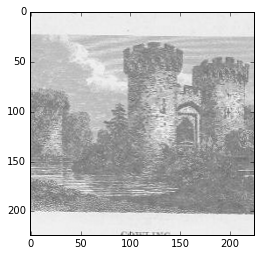

In [49]:
x = [(a.name, a.values()) for a in sess.graph.get_operations()]
for layer, values in x[:20]:
    print layer
    #res = values[0].eval()
    
#pool3_tensor = sess.graph.get_tensor_by_name(':0')
image = to_rgb(image_hdf5['Chunk5'][0][:,:,0])
print np.array(image).shape
plt.imshow(image, cmap=mpl.cm.gray)

# x = [(a.name, a.values()) for a in sess.graph.get_operations()]
# for layer, values in x[:20]:
#     print layer

#sess.run(pool3_tensor, {'ExpandDims:0': a})

In [38]:
date_to_pool3_scores = {}
date_to_softmax_scores = {}
pool3_tensor = sess.graph.get_tensor_by_name('pool_3:0')

for era in date_to_images:
    print era
    date_to_pool3_scores[era] = {}
    date_to_softmax_scores[era] = {}

    for img in date_to_images[era]:
        idx = date_to_images[era][img]
        
        chk = idx/5000
        chunk = "Chunk" + str(chk)
        i = idx % 5000
        if chunk not in image_hdf5: continue

        a = [to_rgb(image_hdf5[chunk][i][:,:,0])]
        predictions = sess.run(pool3_tensor, {'ExpandDims:0': a})[:,0,0,:]
        date_to_pool3_scores[era][img] = predictions[0]
        
        scores = np.dot(predictions, fw) + fb
        scores = np.array([softmax(scores[j]) for j in range(scores.shape[0])])
        date_to_softmax_scores[era][img] = scores[0]

pickle.dump((date_to_pool3_scores, date_to_softmax_scores), open("/data/decorations_by_date/pool3_softmax_scores.pkl", 'w'))

1870-1889
1750-1799
post-1890
pre-1700
1700-1749
1800-1849
1850-1869


In [36]:
date_to_pool3_scores

{'1870-1889': {'000359422_0_000208_4_': array([ 0.33917966,  0.48766357,  0.25737214, ...,  0.36169407,
          0.06452784,  0.09369817], dtype=float32)}}

In [37]:
date_to_softmax_scores

{'1870-1889': {'000359422_0_000208_4_': array([  8.48495811e-02,   6.71020746e-02,   5.89085340e-01,
           1.77142967e-04,   9.05300622e-05,   1.19257413e-06,
           2.58694082e-01], dtype=float32)}}

In [39]:
import pandas as pd
import seaborn as sns

In [42]:
# learn the order of labels
date_to_softmax_arr = {}
for era in date_to_softmax_scores:
    date_to_softmax_arr[era] = pd.DataFrame.from_dict(date_to_softmax_scores[era]).mean(axis=1)
date_to_softmax_arr = pd.DataFrame.from_dict(date_to_softmax_arr)

In [43]:
date_to_softmax_arr

,1700-1749,1750-1799,1800-1849,1850-1869,1870-1889,post-1890,pre-1700
0,0.039132,0.041221,0.162318,0.437587,0.235120,0.191871,0.006641
1,0.078444,0.080790,0.528406,0.146388,0.083443,0.096569,0.011241
2,0.022062,0.013654,0.071375,0.162190,0.317262,0.211979,0.002569
3,0.083071,0.684972,0.054662,0.018775,0.009832,0.009446,0.011621
4,0.680799,0.132965,0.052746,0.019910,0.010990,0.021508,0.038627
5,0.061518,0.022232,0.010662,0.007170,0.002244,0.008356,0.923422
6,0.034974,0.024166,0.119831,0.207981,0.341109,0.460271,0.005881


In [45]:
labels = ["1850-1869", "1800-1849", "1870-1889", "1750-1799", "1700-1749", "pre-1700", "post-1890"]
labels_sorted = ["pre-1700", "1700-1749", "1750-1799", "1800-1849", "1850-1869", "1870-1889", "post-1890"]
labels_idx_pos = [labels]
date_to_softmax_arr = date_to_softmax_arr[labels]
date_to_softmax_arr

,1850-1869,1800-1849,1870-1889,1750-1799,1700-1749,pre-1700,post-1890
0,0.437587,0.162318,0.235120,0.041221,0.039132,0.006641,0.191871
1,0.146388,0.528406,0.083443,0.080790,0.078444,0.011241,0.096569
2,0.162190,0.071375,0.317262,0.013654,0.022062,0.002569,0.211979
3,0.018775,0.054662,0.009832,0.684972,0.083071,0.011621,0.009446
4,0.019910,0.052746,0.010990,0.132965,0.680799,0.038627,0.021508
5,0.007170,0.010662,0.002244,0.022232,0.061518,0.923422,0.008356
6,0.207981,0.119831,0.341109,0.024166,0.034974,0.005881,0.460271


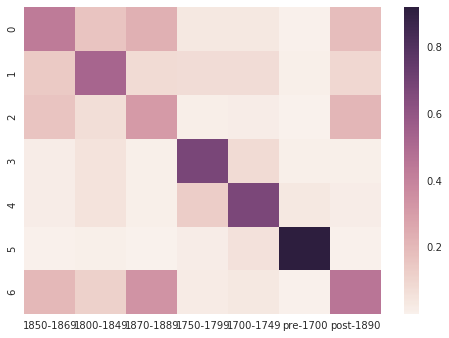

In [46]:
sns.heatmap(date_to_softmax_arr)  # we can see that the closer the dates the more likely things are to cluster

In [50]:
# heatmap it, rank neurons from low->high to high->low
date_to_pool3_arr = {}
for era in date_to_softmax_scores:
    date_to_pool3_arr[era] = pd.DataFrame.from_dict(date_to_pool3_scores[era]).mean(axis=1)
date_to_pool3_arr = pd.DataFrame.from_dict(date_to_pool3_arr)
date_to_pool3_arr = date_to_pool3_arr[labels_sorted]

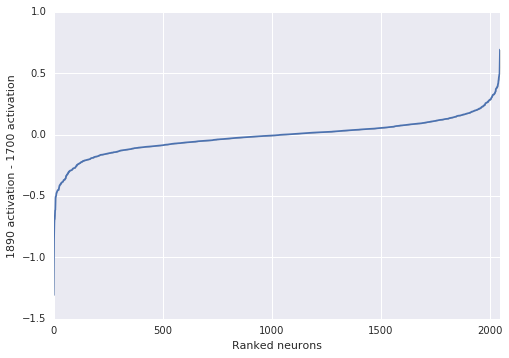

In [77]:
diff = date_to_pool3_arr["post-1890"] - date_to_pool3_arr["pre-1700"]
diff.sort_values(inplace=True)
sns.tsplot(diff)
plt.xlabel("Ranked neurons")
plt.ylabel("1890 activation - 1700 activation")

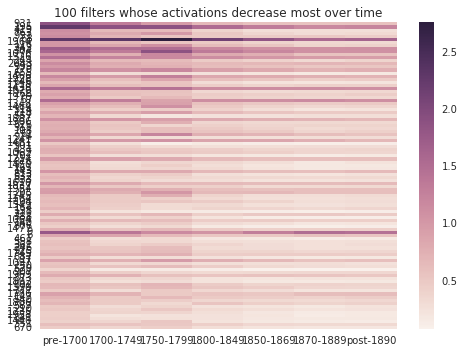

In [74]:
sns.heatmap(date_to_pool3_arr.iloc[diff.index[:100]])
plt.title("100 filters whose activations decrease most over time")

In [79]:
date_to_pool3_arr.iloc[diff.index[:5]]

,pre-1700,1700-1749,1750-1799,1800-1849,1850-1869,1870-1889,post-1890
931,1.888131,1.325364,0.967477,0.682856,0.579481,0.577527,0.581462
195,2.293038,1.880360,1.878607,1.550050,1.338016,1.192686,1.229717
419,1.139803,0.682876,0.651735,0.398961,0.305353,0.290194,0.281249
763,1.082676,0.830684,1.016860,0.525038,0.376804,0.314085,0.331665
951,1.154896,0.726793,0.569372,0.501456,0.492550,0.518386,0.467782


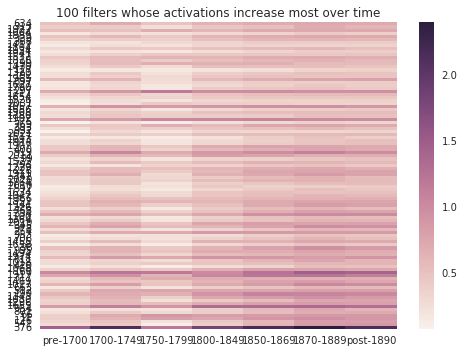

In [73]:
sns.heatmap(date_to_pool3_arr.iloc[diff.index[-100:]])
plt.title("100 filters whose activations increase most over time")

In [83]:
date_to_pool3_arr.iloc[diff.index[-5:]]

,pre-1700,1700-1749,1750-1799,1800-1849,1850-1869,1870-1889,post-1890
66,0.409132,0.716593,0.916283,0.841083,0.870123,0.880397,0.885531
11,0.404151,0.650432,0.814286,0.762257,0.917762,0.978023,0.894662
126,0.343460,0.497795,0.235274,0.457614,0.603215,0.830672,0.839081
541,0.285812,0.456036,0.128858,0.410659,0.635929,0.851639,0.886203
376,1.470577,2.134178,1.214491,1.828239,2.172730,2.405102,2.163369


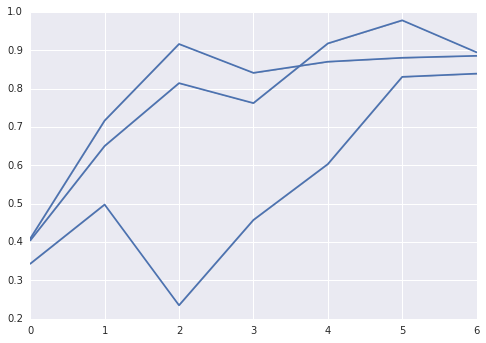

In [86]:
sns.tsplot(date_to_pool3_arr.iloc[diff.index[-5:]].iloc[0])
sns.tsplot(date_to_pool3_arr.iloc[diff.index[-5:]].iloc[1])
sns.tsplot(date_to_pool3_arr.iloc[diff.index[-5:]].iloc[2])

In [ ]:
# can do clustering so that we can see which neurons are most activated for each era


In [ ]:
# what other layers are there that we could look at?